Active Contours using Level Sets
================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This tour explores image segementation using level set methods.

In [2]:
options(warn=-1) # turns off warnings, to turn on: "options(warn=0)"


library(imager)
library(png)

for (f in list.files(path="nt_toolbox/toolbox_general/", pattern="*.R")) {
    source(paste("nt_toolbox/toolbox_general/", f, sep=""))
}

for (f in list.files(path="nt_toolbox/toolbox_signal/", pattern="*.R")) {
    source(paste("nt_toolbox/toolbox_signal/", f, sep=""))
}

source("nt_toolbox/toolbox_wavelet_meshes/meshgrid.R")
options(repr.plot.width=3.5, repr.plot.height=3.5)

Managing level set functions
----------------------------
In the level set formalism, the evolution of some curve $ (\ga(t))_{t=0}^1 $
is computed by evolving the
zero level of a function $\phi : \RR^2 \rightarrow \RR $
$$ \enscond{\ga(s)}{ s \in [0,1] } = \enscond{x \in \RR^2}{\phi(x)=0}. $$
This corresponds to replacing the parameteric representation $\ga$ of
the curve by an implicit representation. This requires an additional
dimension (and hence more storage) but ease the handling of topological
change of the curve during the evolution.


Discretazion size $n \times n$ of the domain $[0,1]^2$.

In [3]:
n <- 200
grid <- meshgrid_2d(1:n, 1:n)
Y <- grid$X ; X <- grid$Y

One can create a circular shape by using the signed distance function to
a circle
$$ \phi_1(x) = \sqrt{ (x_1-c_1)^2 + (x_2-c_2)^2 } - r $$
where $r>0$ is the radius and $c \in \RR^2$ the center.


Radius $r$.

In [4]:
r <- n/3.

Center $c$.

In [5]:
c <- c(r,r) + 10

Distance function $\phi_1$.

In [6]:
phi1 <- sqrt((X-c[1])**2 + (Y-c[2])**2) - r

__Exercise 1__

Load a square shape $\phi_2$ at a different position for the center.

In [7]:
source("nt_solutions/segmentation_3_snakes_levelset/exo1.R")

In [8]:
## Insert your code here.

Display the curves associated to $\phi_1$ and $\phi_2$.

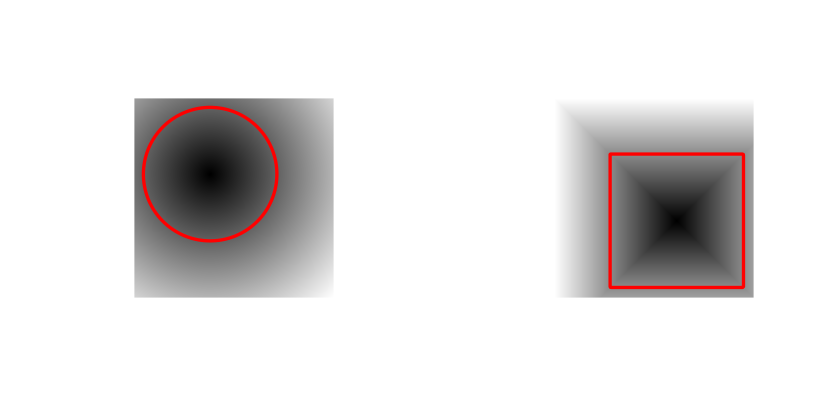

In [9]:
options(repr.plot.width=7, repr.plot.height=3.5)
par(mfrow=c(1,2))

plot_levelset(phi1, lw=2)

plot_levelset(phi2, lw=2)

__Exercise 2__

Compute the intersection and the union of the two shapes.
Store the union in $\phi_0$ (phi0)
that we will use in the remaining part of the tour.

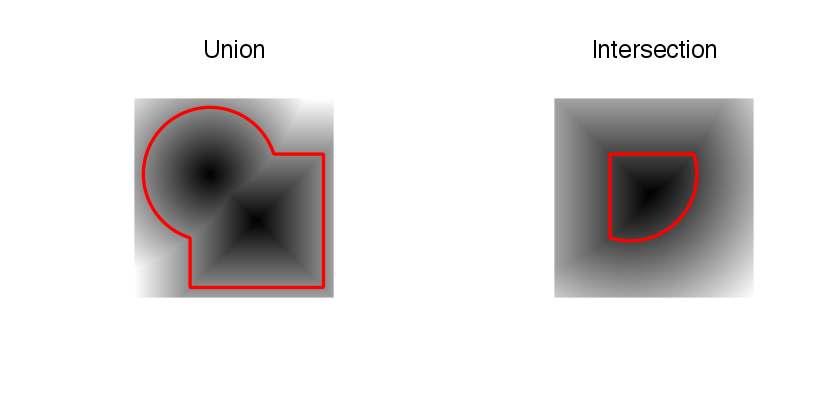

In [10]:
source("nt_solutions/segmentation_3_snakes_levelset/exo2.R")

In [11]:
## Insert your code here.

Mean Curvature Motion.
----------------------
The mean curvature motion corresponds to the minimizing flow of the
length of the curve
$$ \int_0^1 \norm{\ga'(s)} d s. $$



It is implemeted in a level set formalism by a familly $\phi_t$ of
level set function parameterized by an artificial time $t \geq 0$, that
satisfies the following PDE
$$ \pd{\phi_t}{t} = -G(\phi_t)
  \qwhereq G(\phi) = -\norm{\nabla \phi} \text{div}
      \pa{  \frac{\nabla \phi}{\norm{\nabla \phi}} }  $$
and where $\nabla \phi_t(x) \in \RR^2$ is the spacial gradient.


This flow is computed using a gradient descent
$\phi^{(0)} = \phi_0$ and
$$ \phi^{(\ell+1)} = \phi^{(\ell)} - \tau G(\phi^{(\ell)}), $$
where $\tau>0$ is small enough time step.


Maximum time of the evolution $0 \leq t \leq t_{\max}$.

In [12]:
Tmax <- 200

Time step $\tau>0$ (should be small).

In [13]:
tau <- .5

Number of iterations.

In [14]:
niter <- as.integer(Tmax/tau)

Initial shape $\phi^{(0)}$ at $t=0$.

In [15]:
phi <- phi0

We now compute the right hand side of the evolution equation.


Compute the gradient $\nabla \phi$. We use centered differences for the discretization of the gradient.

In [16]:
g0 <- grad(phi, order=2)

Norm $\norm{\nabla \phi}$ of the gradient.

In [17]:
eps <- .Machine$double.eps
d <- pmax( eps*array(1,c(n,n)), sqrt(apply(g0**2, c(1,2), sum)) )

Normalized gradient.

In [18]:
g <- g0/array(rep(d,2), c(dim(d),2))

The curvature term.

In [19]:
K <- - d*div(g[,,1], g[,,2], order=2)

Perform one step of the gradient descent.

In [20]:
phi <- phi - tau*K

__Exercise 3__

Implement the mean curvature motion.

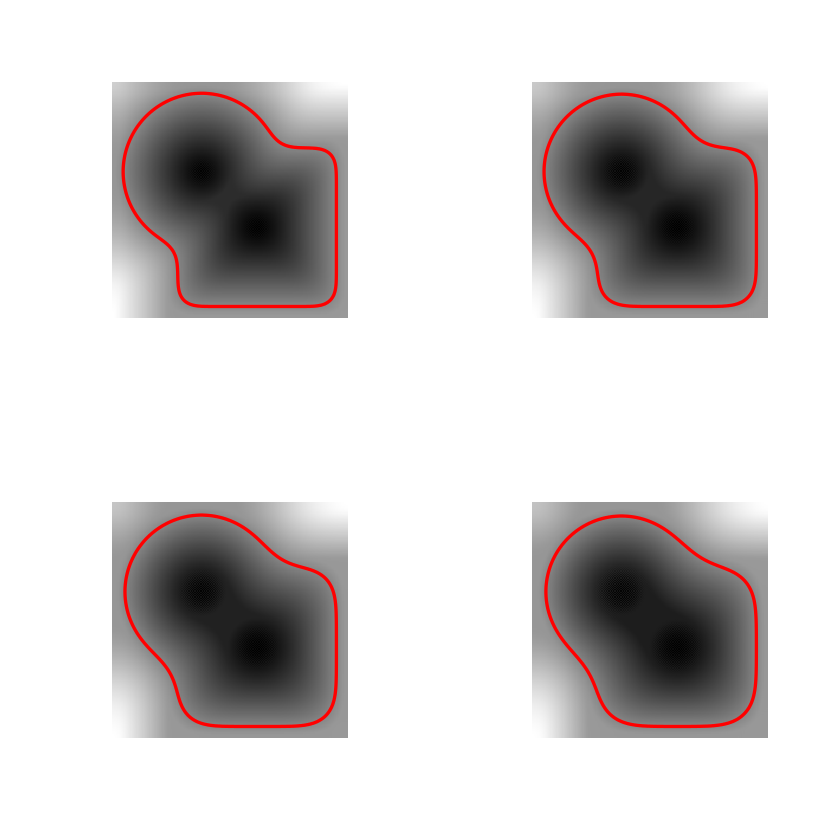

In [21]:
options(repr.plot.width=7, repr.plot.height=7)

source("nt_solutions/segmentation_3_snakes_levelset/exo3.R")

In [22]:
## Insert your code here.

Edge-based Segmentation with Geodesic Active Contour
----------------------------------------------------
Geodesic active contours compute loval minimum of a weighted geodesic
distance that attract the curve toward the features of the background
image.


_Note:_ these active contours should not be confounded with the geodesic shortest paths,
that are globally minimizing geodesics between two points.
Here the active contour is a close curve progressively decreasing a
weighted geodesic length that is only a local minimum
(the global minimum would be a single point).


Size of the image.

In [23]:
n <- 200

First we load an image $f_0 \in \RR^{n \times n}$ to segment.

In [24]:
f0 <- rescale(as.matrix(load_image("nt_toolbox/data/cortex.png", n)))

Given a background image $f_0$ to segment, one needs to compute
an edge-stopping function $W$.
It should be small in area of high gradient, and high in area of large gradient.


We use here
$$ W(x) = \al + \frac{\be}{\epsilon + d(x) }
      \qwhereq d = \norm{\nabla f_0} \star h_a, $$
and where $h_a$ is a blurring kernel of size $a>0$.


Compute the magnitude of the gradient $d_0(x) = \norm{\nabla f_0(x)}$.

In [25]:
g <- grad(f0, order=2)
d0 <- sqrt(apply(g**2, c(1,2), sum))

Blur size $a$.

In [26]:
a <- 5

Compute the blurring $d = d_0 \star h_a$.

In [27]:
d <- perform_blurring(d0, c(a), bound="per")

[1] 21 21


Parameter $\epsilon>0$.

In [28]:
epsilon <- 1e-1

We set the $\al$ and $\be$ parameters to adjust the overall values of $W$
(equivalently we use the function rescale).

In [29]:
W <- 1./(epsilon + d)
W <- rescale(-W, 0.1, 1)

Display it.

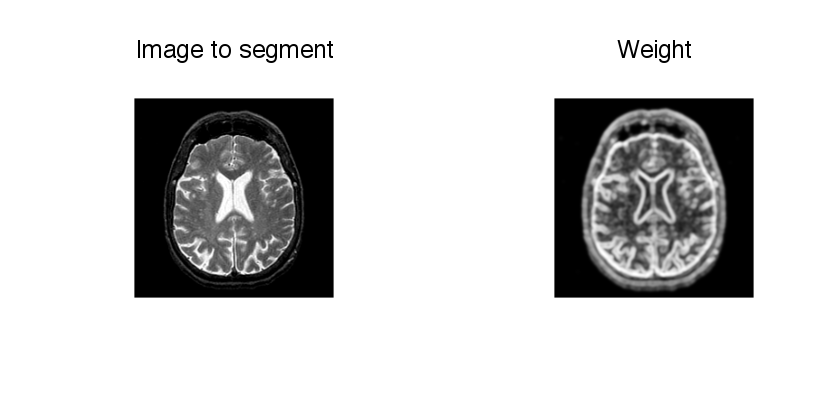

In [30]:
options(repr.plot.width=7, repr.plot.height=3.5)

imageplot(f0, "Image to segment", c(1,2,1))
imageplot(W, "Weight", c(1,2,2))

__Exercise 4__

Compute an initial shape $\phi_0$ at time $t=0$,
for instance a centered square.

In [31]:
source("nt_solutions/segmentation_3_snakes_levelset/exo4.R")

In [32]:
## Insert your code here.

Display it.

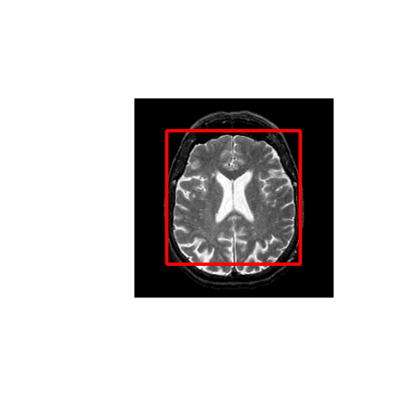

In [33]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

plot_levelset(phi0, f0, lw=2)

The geodesic active contour minimizes a weighted length of curve
$$ \umin{\ga} \int_0^1 \norm{\ga'(s)} W(\ga(s)) d s $$


The level set implementation of the gradient descent of this energy reads
$$ \pd{\phi_t}{t} = G(\phi_t)
  \qwhereq G(\phi) = -\norm{\nabla \phi} \text{div}\pa{
          W \frac{\nabla \phi}{\norm{\nabla \phi}}
  } $$


This is implemented using a gradient descent scheme.
$$ \phi^{(\ell+1)} = \phi^{(\ell)} - \tau G(\phi^{(\ell)}), $$
where $\tau>0$ is small enough.


Gradient step size $\tau>0$.

In [34]:
tau <- .4

Final time and number of iteration of the algorithm.

In [35]:
Tmax <- 1500
niter <- as.integer(Tmax/tau)

Initial distance function $\phi^{(0)}=\phi_0$.

In [36]:
phi <- phi0

Note that we can re-write the gradient of the energy as
$$ G(\phi) = -W \norm{\nabla \phi} \text{div} \pa{ \frac{\nabla \phi}{\norm{\nabla \phi}}  } - \dotp{\nabla W}{\nabla \phi} $$


Pre-compute once for all $\nabla W$.

In [37]:
gW <- grad(W, order=2)

__Exercise 5__

Compute and store in G the gradient $G(\phi)$ (right hand side of the PDE)
using the current value of the distance function $\phi$.

In [38]:
source("nt_solutions/segmentation_3_snakes_levelset/exo5.R")

In [39]:
## Insert your code here.

Do the descent step.

In [40]:
phi <- phi - tau*G

__Exercise 6__

Implement the geodesic active contours gradient descent.

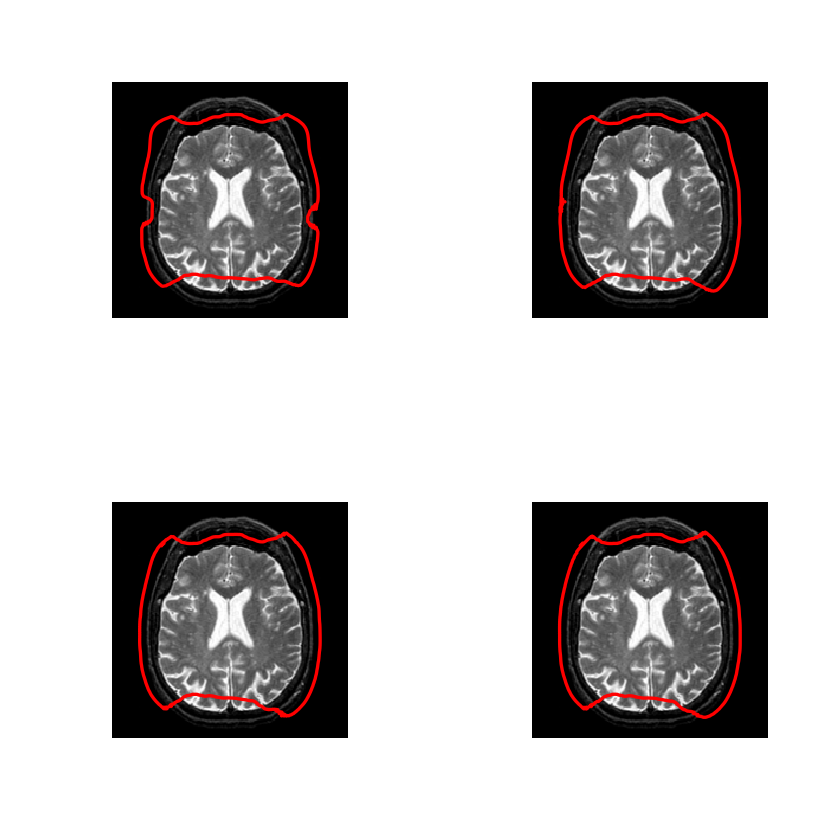

In [41]:
options(repr.plot.width=7, repr.plot.height=7)

source("nt_solutions/segmentation_3_snakes_levelset/exo6.R")

In [42]:
## Insert your code here.

Region-based Segmentation with Chan-Vese 
-----------------------------------------
Chan-Vese active contours corresponds to a region-based energy
that looks for a piecewise constant approximation of the image.


The energy to be minimized is
$$ \umin{\phi}
      L(\phi) +
      \la \int_{\phi(x)>0} \abs{f_0(x)-c_1}^2 d x   +
      \la \int_{\phi(x)<0} \abs{f_0(x)-c_2}^2 d x
$$
where $L$ is the length of the zero level set of $\phi$.
Note that here $(c_1,c_2) \in \RR^2$ are assumed to be known.

__Exercise 7__

Compute an initial level set function $\phi_0$, stored in phi0,
for instance many small circles.

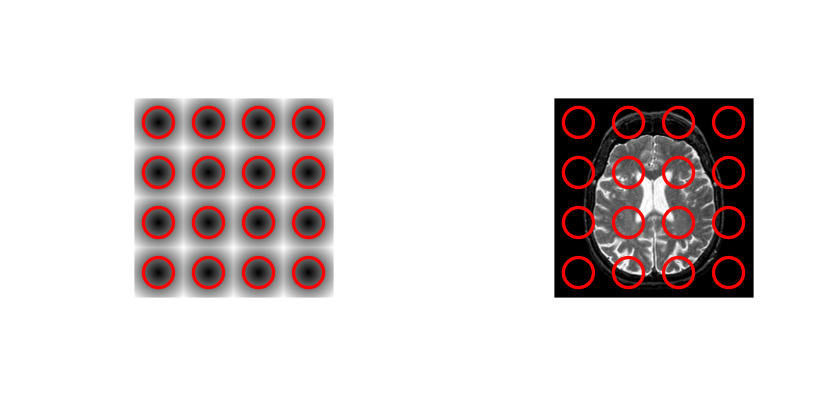

In [43]:
options(repr.plot.width=7, repr.plot.height=3.5)

source("nt_solutions/segmentation_3_snakes_levelset/exo7.R")

In [44]:
## Insert your code here.

Parameter $\la$

In [45]:
lambd <- 2

Values for $c_1,c_2$

In [46]:
c1 <- .7
c2 <- 0

Step size.

In [47]:
tau <- .5

Number of iterations.

In [48]:
Tmax <- 100
niter <- as.integer(Tmax/ tau)

Initial distance function $\phi_0$ at time $t=0$.

In [49]:
phi <- phi0

The minimizing flow for the CV energy reads
$$ \pd{\phi_t}{t} = - G(\phi_t) $$
where
$$ G(\phi) =
- W \norm{\nabla \phi} \text{div}\pa{
	\frac{\nabla \phi}{\norm{\nabla \phi}}
} + \la (f_0-c_1)^2 - \la (f_0-c_2)^2. $$

__Exercise 8__

Compute this gradient $G(\phi)$ using the current value of the distance function

In [50]:
source("nt_solutions/segmentation_3_snakes_levelset/exo8.R")

In [51]:
## Insert your code here.

Do a descent step.

In [52]:
phi <- phi + tau*G

__Exercise 9__

Implement the full gradient descent.

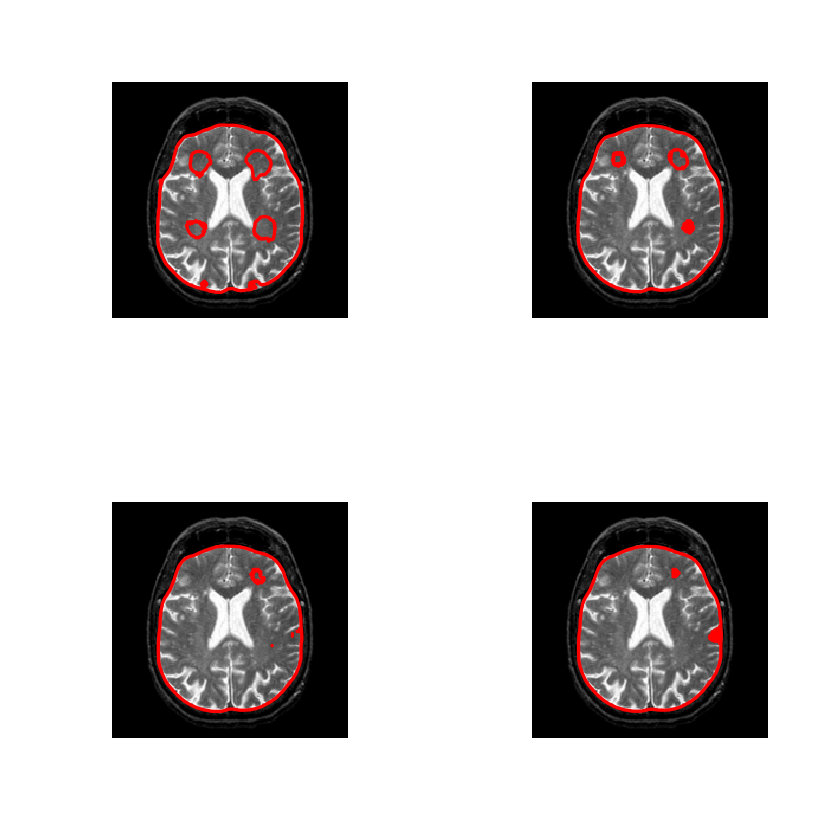

In [53]:
options(repr.plot.width=7, repr.plot.height=7)

source("nt_solutions/segmentation_3_snakes_levelset/exo9.R")

In [54]:
## Insert your code here.